In [1]:
import warnings
import healpy as hp
from astroquery.gaia import Gaia
import tqdm
import pickle
from astropy import table
import numpy as np
import matplotlib.pyplot as plt
import astropy.coordinates as coord
import astropy.units as u
import sklearn
from sklearn import metrics
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.utils import shuffle
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
from sklearn.utils import shuffle
import scipy.signal as sig
import seaborn as sns
import scipy.interpolate as interp
from scipy.stats import gaussian_kde

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def plot_parallax_prediction(Xtrue, ytrue, kde, ypred1, ypred2, ypred3, fids):
    """"""
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(
        xlabel=r"$\log_{10}$ parallax [mas]",
        ylabel=r"$\log_{10}$ parallax fractional error",
    )
    # distance label
    secax = ax.secondary_xaxis(
        "top",
        functions=(
            lambda logp: np.log10(
                coord.Distance(parallax=10 ** logp * u.mas).to_value(u.pc)
            ),
            lambda logd: np.log10(
                coord.Distance(10 ** logd * u.pc).parallax.to_value(u.mas)
            ),
        ),
    )
    secax.set_xlabel(r"$\log_{10}$ Distance [kpc]")
    
    Xpred = np.array(
    [
        np.ones(100) * np.median(Xtrue[:, 0]),  # ra
        np.ones(100) * np.median(Xtrue[:, 1]),  # dec
        np.linspace(Xtrue[:, 2].min(), Xtrue[:, 2].max(), 100),  # p
    ]
    ).T

    ax.scatter(Xtrue[:, -1], ytrue, s=5, label="data", alpha=0.3, c=kde)
    ax.scatter(Xpred[:, -1], ypred1, s=5, label="kernel-ridge")
    ax.scatter(Xpred[:, -1], ypred2, s=5, label="linear model: density-weighting")
    ax.scatter(Xpred[:, -1], ypred3, s=5, label="linear model: no density weight")
    ax.set_title(str(fids))
    
    ax.set_ylim(-3, 3)
    ax.invert_xaxis()
    ax.legend()

    return fig

def kernel_ridge(X, y, train_size):
    "Kernel-Ridge Regression code"
    rng = np.random.default_rng()
    kr = GridSearchCV(
        KernelRidge(kernel="linear", gamma=0.1),
        param_grid={
            "alpha": [1e0, 0.1, 1e-2, 1e-3],
            "gamma": np.logspace(-2, 2, 5),
        },
    )
    
    # randomize the data order
    idx = shuffle(np.arange(0, len(X)), n_samples=train_size)

    # Fitting using the Kernel-Ridge Regression
    kr.fit(X[idx], y[idx])
    Xp = np.array(
        [
            np.ones(100) * np.median(X[:, 0]),  # ra
            np.ones(100) * np.median(X[:, 1]),  # dec
            np.linspace(X[:, 2].min(), X[:, 2].max(), 100),  # p
        ]
    ).T
    ykr = kr.predict(Xp)
    return ykr, kr

def Gauss_process(X,y, train_size):
    "Gaussian-Process Regression code"
    rng = np.random.default_rng()
    idx = shuffle(np.arange(0, len(X)), n_samples=train_size)
    gpr = GaussianProcessRegressor(kernel=None)
    gpr.fit(X[idx], y[idx])
    ygp = gpr.predict(Xp)
    return ygp, gpr

def support_vector(X,y, train_size):
    "support-vector regression code"
    rng = np.random.default_rng()
    svr = GridSearchCV(SVR(kernel='linear', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
    
    # randomize the data order
    idx = shuffle(np.arange(0, len(X)), n_samples=train_size)

    # Fitting using the Kernel-Ridge Regression
    kr.fit(X[idx], y[idx])
    Xp = np.array(
        [
            np.ones(100) * np.median(X[:, 0]),  # ra
            np.ones(100) * np.median(X[:, 1]),  # dec
            np.linspace(X[:, 2].min(), X[:, 2].max(), 100),  # p
        ]
    ).T
    svr.fit(X[idx], y[idx])
    ysv = svr.predict(Xp)
    return ysv, svr

def linear(X, y, train_size, weight=True):
    "linear regression model"
    reg = linear_model.LinearRegression()
    
    # randomize the data order
    idx = shuffle(np.arange(0, len(X)), n_samples=train_size)
    xy = np.vstack([X[:,2],y])
    kde = gaussian_kde(xy)(xy)
    if weight==True:
        reg.fit(X[idx], y[idx], sample_weight=(1/kde)[idx])
    else:
        reg.fit(X[idx], y[idx])
    Xp = np.array(
        [
            np.ones(100) * np.median(X[:, 0]),  # ra
            np.ones(100) * np.median(X[:, 1]),  # dec
            np.linspace(X[:, 2].min(), X[:, 2].max(), 100),  # p
        ]
    ).T
    yreg = reg.predict(Xp)
    return yreg, reg     

  0%|          | 0/4 [00:00<?, ?it/s]

Approximate resolution at NSIDE 16 is 3.7 deg
INFO: Query finished. [astroquery.utils.tap.core]
    source_id      healpix4 ...        dec               dec_err       
                            ...        deg                 mas         
------------------ -------- ... ------------------ --------------------
693548776338020096      307 ...   29.8498920125955  0.21211038543232402
693000497992365824      307 ... 27.491434319182193    0.476724832168788
692974320168744320      307 ... 28.188484701976375  0.03181269632131433
693105913670118528      307 ...  28.16084401625269  0.13974470835355274
692899622097680896      307 ... 27.931575027320548  0.11343948826614043
693348149825235456      307 ...  28.44885057452018  0.26419532866363993
693068702072988544      307 ... 27.829419794549324 0.024242986743037404
693139315631823872      307 ... 28.190852193438538   0.8812924101986098
693225764733462912      307 ... 28.633650853598603  0.32096732864077765
692213664280031104      307 ... 27.44022

/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/sklearn

312 30
INFO: Query finished. [astroquery.utils.tap.core]
     source_id      healpix4 ...        dec               dec_err       
                             ...        deg                 mas         
------------------- -------- ... ------------------ --------------------
1817730009071157376      807 ... 21.662967155050644   1.3713663286981779
1817784503614401024      807 ... 20.989581013851687   0.0633113911484616
1818274095528559616      807 ... 22.751236888804687  0.20276826484332666
1818510769700759552      807 ... 21.921660959064756   0.3722178969505268
1818252002213693952      807 ...  22.81338599385573  0.13745937296234612
1819254829835393536      807 ... 23.311011690780244   0.5406264700766295
1817216502783698048      807 ...  19.79088287915166   0.8589768046212571
1818512693849623936      807 ... 21.990655982447915 0.020075777729463118
1818161155067762432      807 ... 22.329670353172343   0.3429433194697062
1819122918503558656      807 ... 23.319884709824326    0.1252309547

/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


811 1386


/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


812 732


 50%|█████     | 2/4 [00:28<00:20, 10.25s/it]

INFO: Query finished. [astroquery.utils.tap.core]
     source_id      healpix4 ...        dec               dec_err       
                             ...        deg                 mas         
------------------- -------- ... ------------------ --------------------
4294197607799880448     1907 ... 5.1473678346168095    0.225571599875313
4295494821064213376     1907 ...  7.144489093239074 0.022968581046481567
4294871127428765312     1907 ...  6.867113938794427   0.9916623689978411
4296412986315559680     1907 ...  9.306153721939458  0.46547854706012415
4295573337415483648     1907 ...   7.40730897402367   0.3105359912141994
4294866626288364160     1907 ...  6.936575361323923  0.32864163544145353
4296239671476409856     1907 ...  8.468026675609158   0.1520894199560941
4294712557227171328     1907 ... 6.6939118592313855   0.6934070075395978
4296419377227543424     1907 ...  9.289146880496046 0.038136726708921306
4294374521794413056     1907 ...  6.056549059110933  0.09208100445077189
 

/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


1909 506


/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


1910 1128


/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


1911 819


/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


1912 525


/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
 75%|███████▌  | 3/4 [00:44<00:12, 12.24s/it]

INFO: Query finished. [astroquery.utils.tap.core]
     source_id      healpix4 ...         dec               dec_err       
                             ...         deg                 mas         
------------------- -------- ... ------------------- --------------------
6547058480267523584     2907 ...  -37.96034382888883  0.06631204934245513
6546380704363020032     2907 ...  -39.86235105717526 0.033712542171488405
6548109132346869888     2907 ... -36.730359139616525 0.025380049861343505
6546810750848649856     2907 ... -38.353975209613196  0.06355134352161856
6547178155235508352     2907 ... -39.106723656312155   0.3018002524729333
6547610194586075648     2907 ... -38.010809400660854  0.15004256347763234
6548105730732899840     2907 ...   -36.7608353194903   0.3147286687287487
6546983958289683712     2907 ...  -38.20056815769601  0.03601732834017389
6548082984586071424     2907 ... -36.706686496367254   0.7021259923919775
6548055462435561600     2907 ...  -36.94904527868239   0.79876

/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/healpy/visufunc.py:200: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = pylab.figure(fig, figsize=(8.5, 5.4))
/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  Dep

2908 16
2909 9


/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results

2910 25
2911 16


/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/cal/ccarr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from th

2912 34


<Figure size 432x288 with 0 Axes>

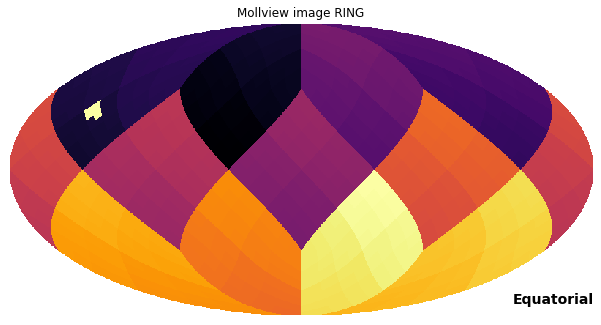

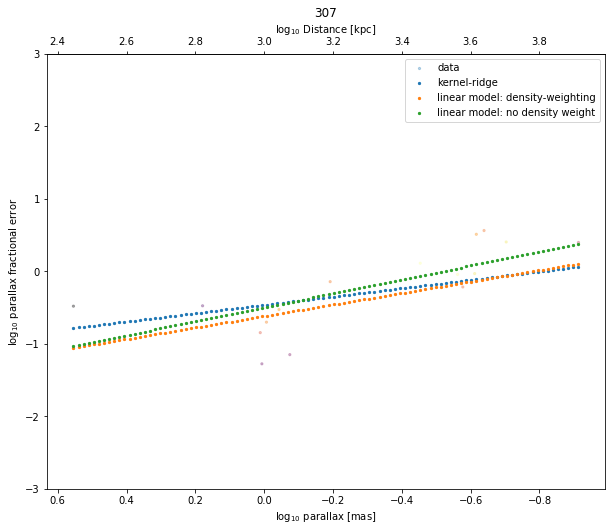

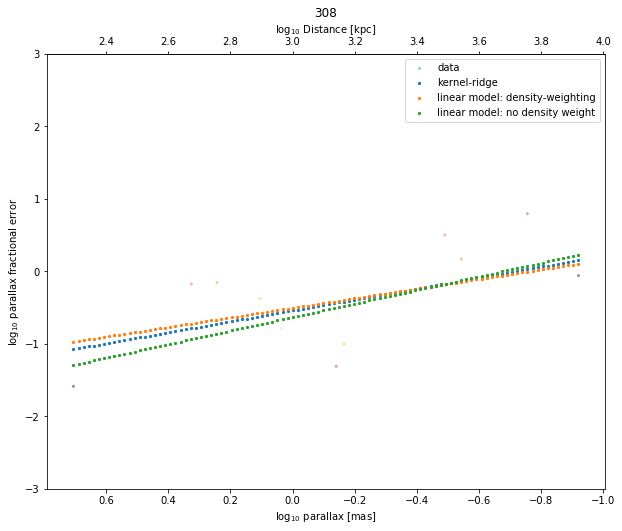

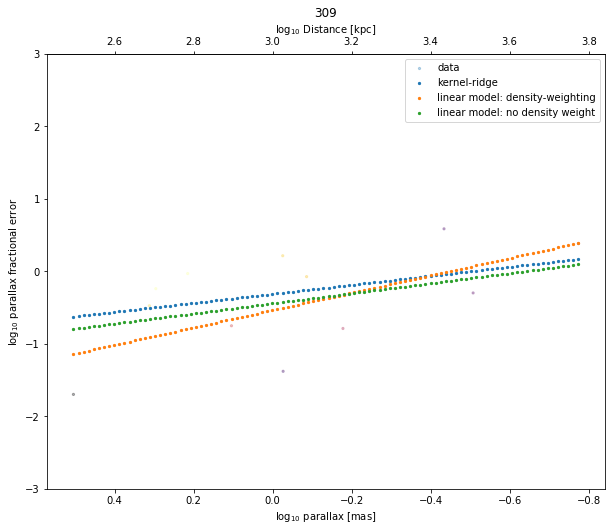

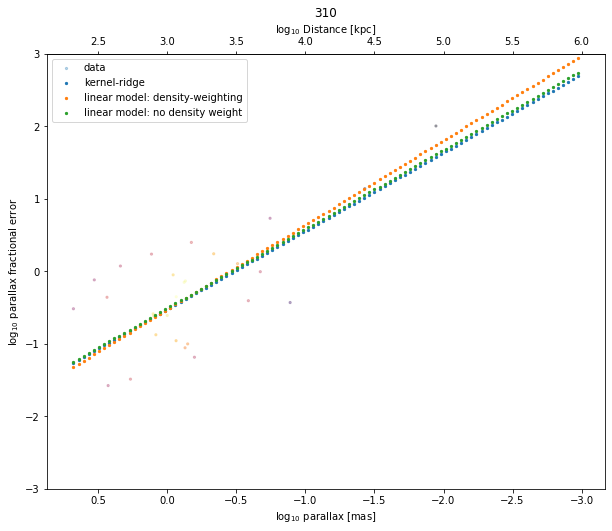

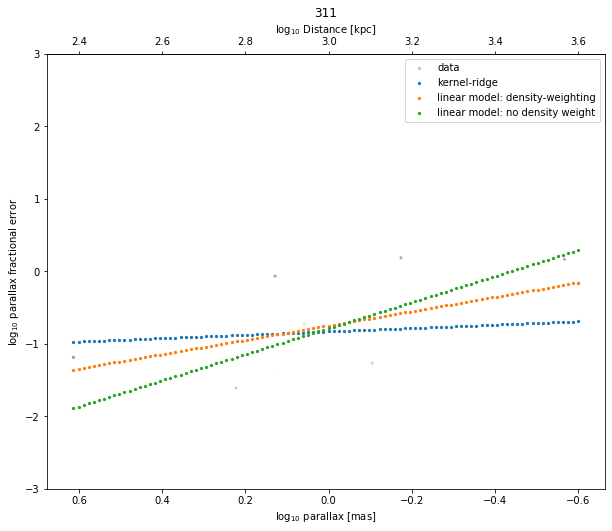

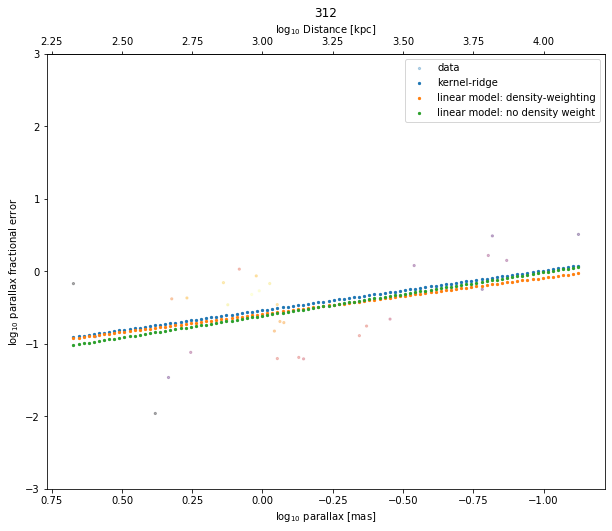

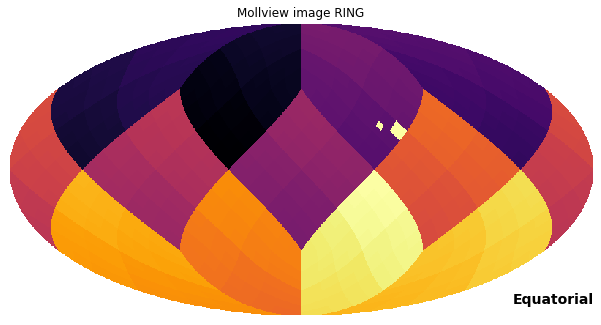

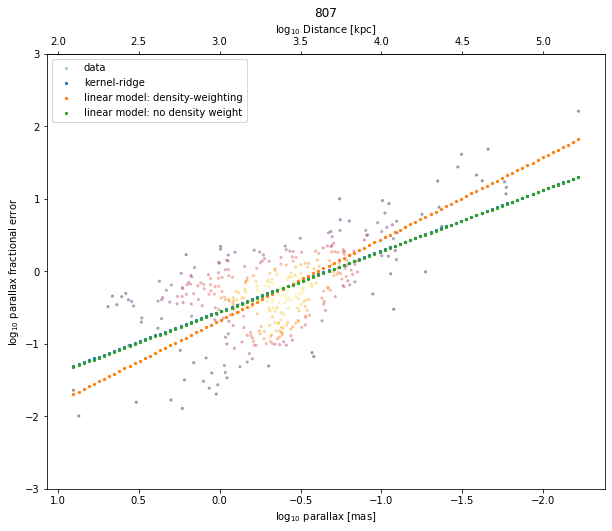

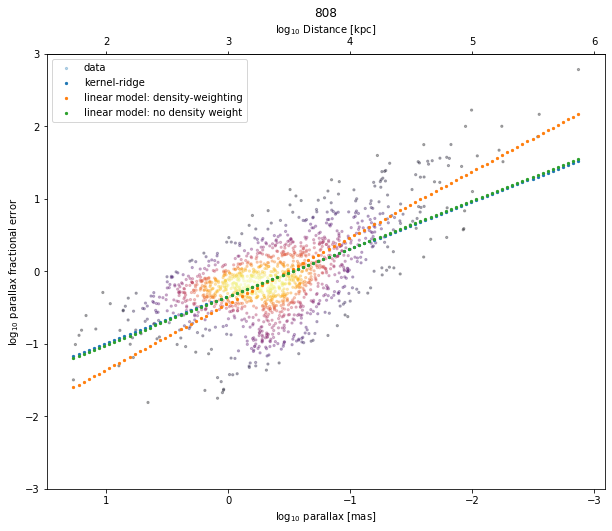

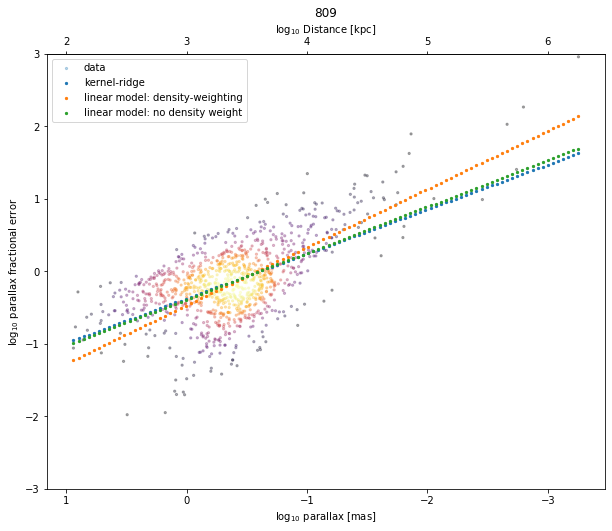

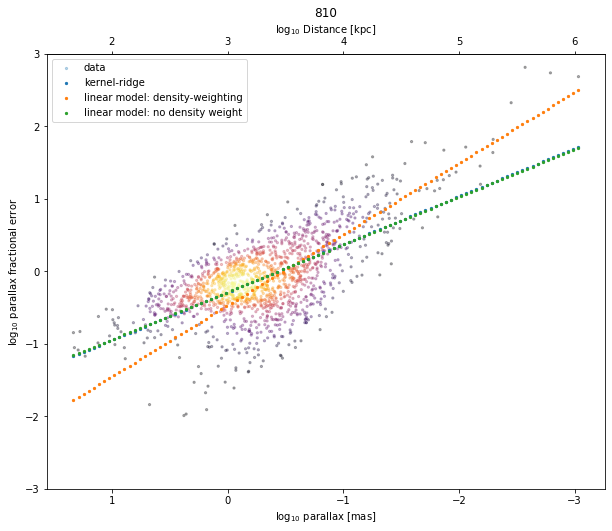

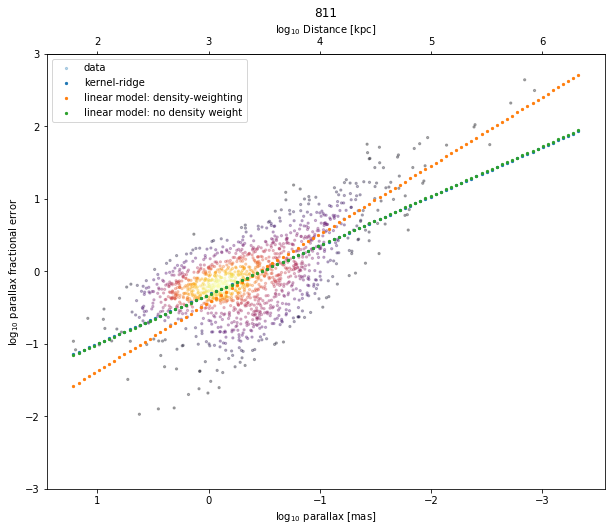

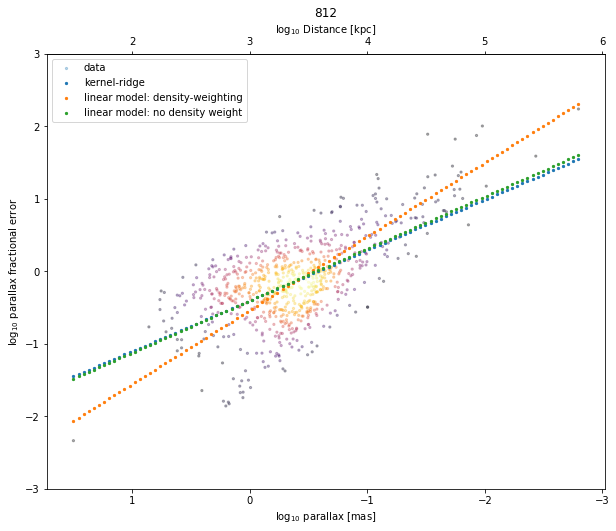

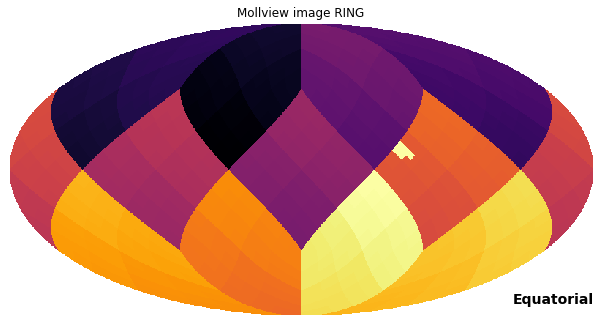

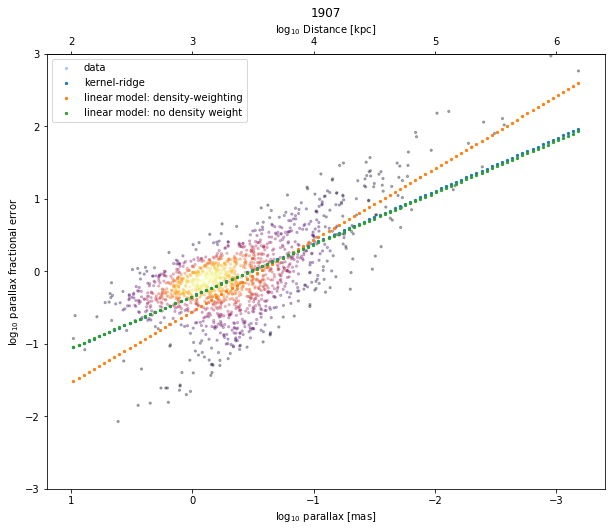

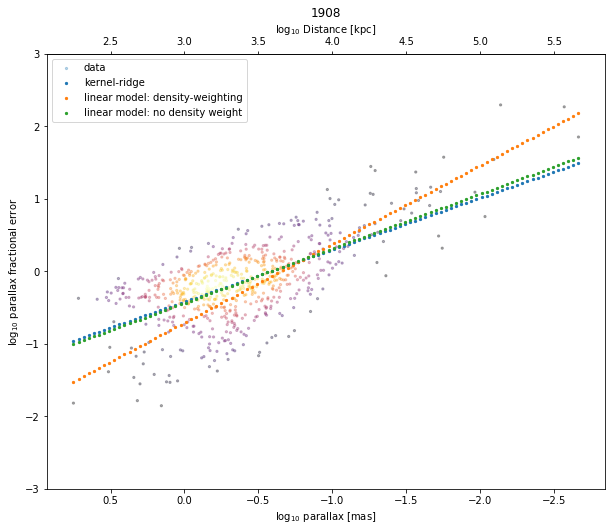

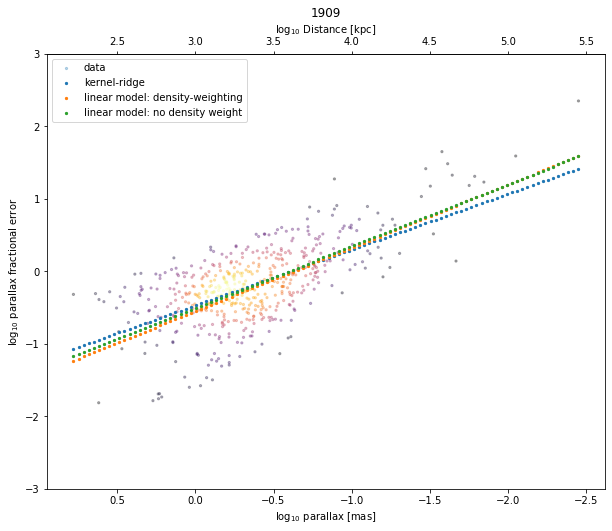

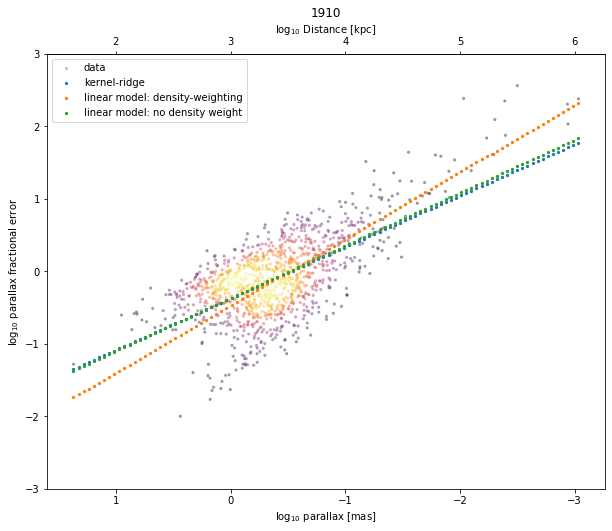

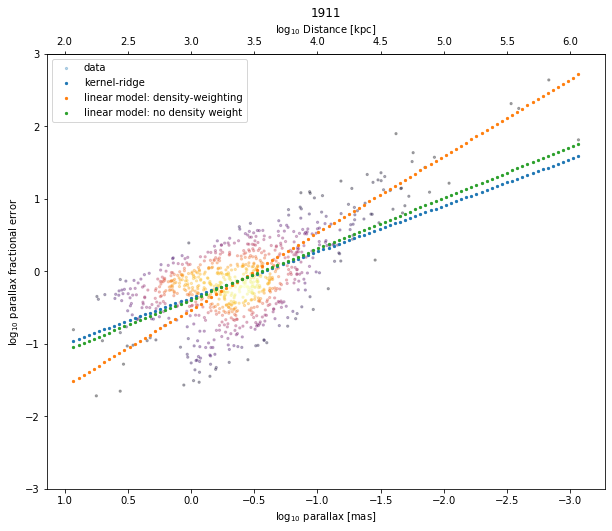

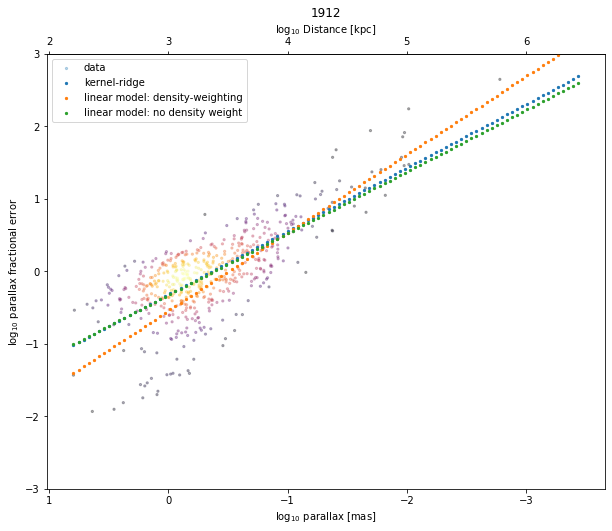

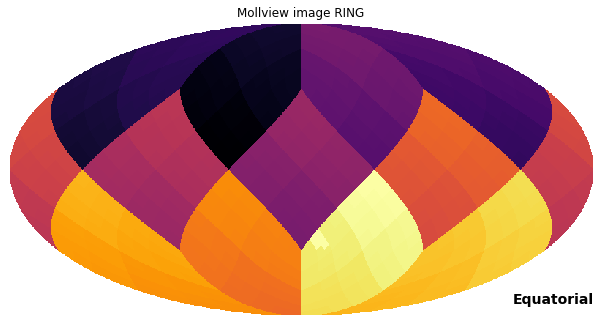

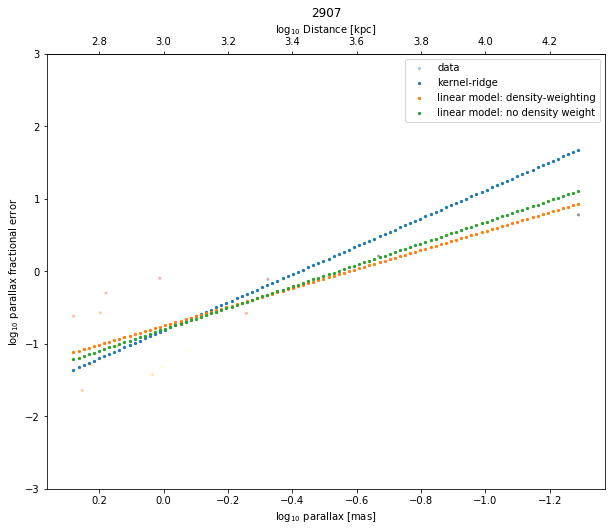

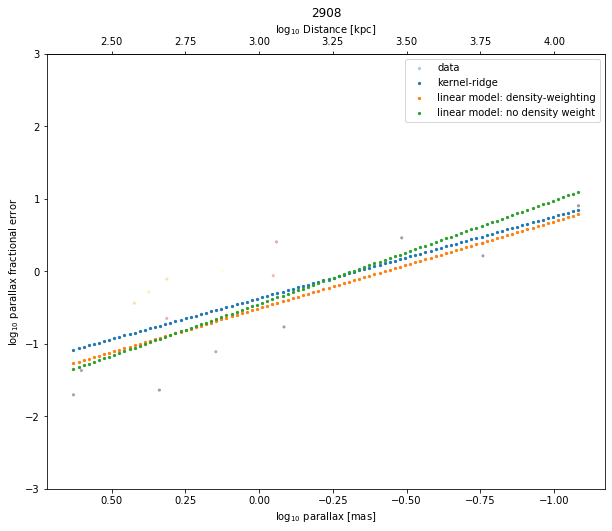

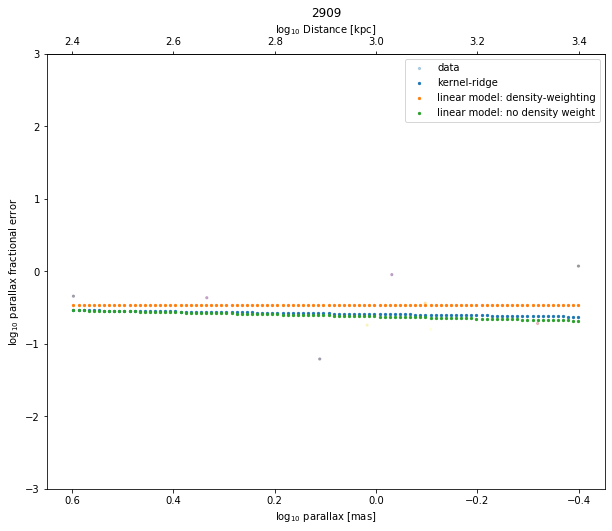

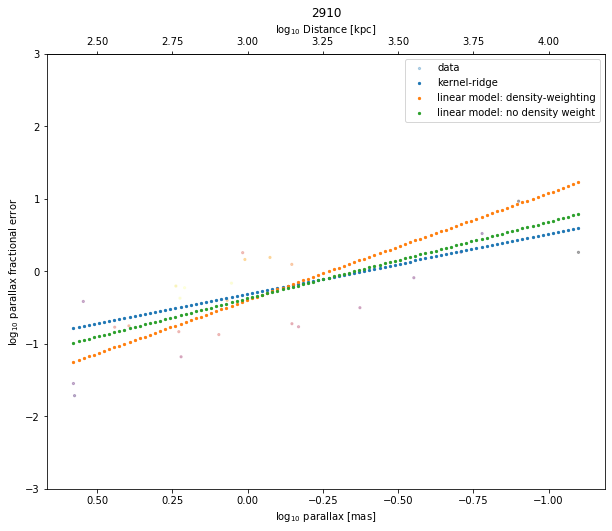

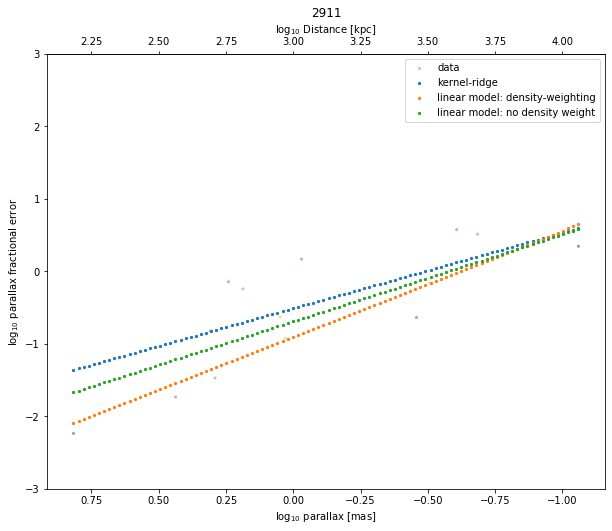

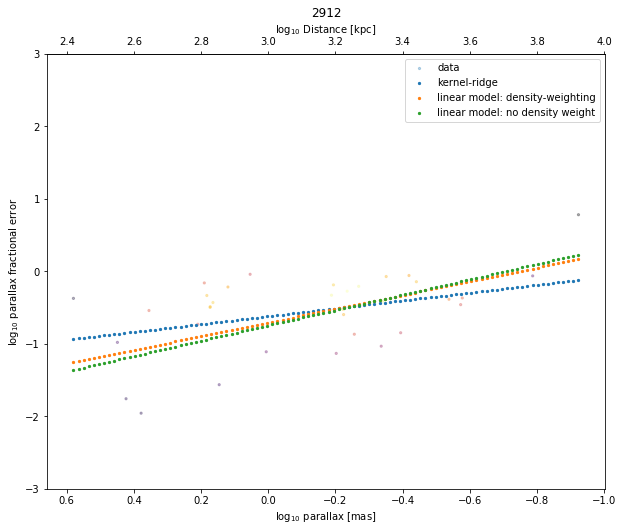

In [3]:
warnings.filterwarnings('ignore', category=FutureWarning)
groups_of_setofids = [(307,308,309,310,311,312),
                     (807,808,809,810,811,812), 
                     (1907,1908,1909,1910,1911,1912), 
                    (2907,2908,2909,2910,2911,2912)]

groups_of_setofids = [(807,808,809,810,811,812,813,814,815,816,817,818)]

NSIDE = hp.order2nside(4) # converts norder to nside
cm = plt.set_cmap('inferno')
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)


for setofids in tqdm.tqdm(groups_of_setofids):
    job = Gaia.launch_job_async(f"""
    SELECT
    source_id, GAIA_HEALPIX_INDEX(4, source_id) AS healpix4,
    parallax AS parallax, parallax_error AS parallax_error,
    ra, ra_error AS ra_err,
    dec, dec_error AS dec_err

    FROM gaiadr2.gaia_source

    WHERE GAIA_HEALPIX_INDEX(4, source_id) IN {setofids}
    AND parallax >= 0
    AND random_index < 1000000
    """, dump_to_file=False, verbose=False, )
    r = job.get_results()
    rgr = r.group_by("healpix4")
    print(rgr)
    
    NPIX = hp.nside2npix(NSIDE)
    m = np.arange(NPIX)
    m[setofids[0]:setofids[-1]] = m.max()
    hp.mollview(m, title="Mollview image RING", nest=True, coord=["C"], cbar=False, cmap=cm)
    
    for j in range(0,len(setofids)):
        rg = rgr[rgr['healpix4']==setofids[j]]
        
        print(setofids[j], len(rg))

        # DOING STUFF HERE
        #with catch_warnings(UserWarning):
        df = table.QTable(rg)

        df = df[np.isfinite(df["parallax"])]  # filter out NaN
        df = df[df["parallax"] > 0]  # positive parallax

        # add the fractional error
        df["parallax_frac_error"] = df["parallax_error"] / df["parallax"]

        X = np.array(
        [
            df["ra"].to_value(u.deg),
            df["dec"].to_value(u.deg),
            np.log10(df["parallax"].to_value(u.mas)),
        ]).T
        y = np.log10(df["parallax_frac_error"].value.reshape(-1, 1))[:,0]

        xy = np.vstack([X[:,2],y])
        kde = gaussian_kde(xy)(xy)

        ykr, kr = kernel_ridge(X, y, train_size=int(len(rg)*0.8))
        #ygp, gpr = Gauss_process(X,y, train_size)
        ysv, svr = support_vector(X,y, train_size=int(len(rg)*0.8))
        yreg, reg = linear(X, y, train_size=int(len(rg)*0.8))
        yreg1, reg1 = linear(X, y, train_size=int(len(rg)*0.8), weight=False)
        
        with open("pk_reg/pk_"+str(setofids[j])+".pkl", mode="wb") as f:
            pickle.dump(reg, f)

        plot_parallax_prediction(X, y, kde, ykr, yreg, yreg1, setofids[j])

In [ ]:
with open("pk_"+str(setofids[-1])+".pkl", mode="rb") as f:
    testreg = pickle.load(f)
    
Xp = np.array(
    [
        np.ones(100) * np.median(X[:, 0]),  # ra
        np.ones(100) * np.median(X[:, 1]),  # dec
        np.linspace(X[:, 2].min(), X[:, 2].max(), 100),  # p
    ]
).T
yreg = testreg.predict(Xp)
    
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(
    xlabel=r"$\log_{10}$ parallax [mas]",
    ylabel=r"$\log_{10}$ parallax fractional error",
)
# distance label
secax = ax.secondary_xaxis(
    "top",
    functions=(
        lambda logp: np.log10(
            coord.Distance(parallax=10 ** logp * u.mas).to_value(u.pc)
        ),
        lambda logd: np.log10(
            coord.Distance(10 ** logd * u.pc).parallax.to_value(u.mas)
        ),
    ),
)
secax.set_xlabel(r"$\log_{10}$ Distance [kpc]")

Xpred = np.array(
[
    np.ones(100) * np.median(X[:, 0]),  # ra
    np.ones(100) * np.median(X[:, 1]),  # dec
    np.linspace(X[:, 2].min(), X[:, 2].max(), 100),  # p
]
).T

ax.scatter(X[:, -1], y, s=2, label="data", alpha=0.3, c=kde)
#ax.scatter(Xpred[:, -1], ypred1, s=2, label="kernel-ridge")
#ax.scatter(Xpred[:, -1], ypred2, s=2, label="linear model: density-weighting")
ax.scatter(Xpred[:, -1], yreg, s=2)
#ax.set_title(str(fids))

ax.set_ylim(-3, 3)
ax.invert_xaxis()
ax.legend()

## Gaia Querying with different healpix levels

In [20]:
groups_of_setofids = [(807,808,809,810)]
for setofids in tqdm.tqdm(groups_of_setofids):
    job = Gaia.launch_job_async(f"""
        SELECT
        source_id, GAIA_HEALPIX_INDEX(5, source_id) AS healpix5,
        parallax AS parallax, parallax_error AS parallax_error,
        ra, ra_error AS ra_err,
        dec, dec_error AS dec_err

        FROM gaiadr2.gaia_source

        WHERE GAIA_HEALPIX_INDEX(5, source_id) IN {setofids}
        AND parallax >= 0
        AND random_index < 2000000
        """, dump_to_file=False, verbose=False, )
    r = job.get_results()
    #rgr = r.group_by("healpix7")


  0%|          | 0/1 [00:00<?, ?it/s]INFO:astropy:Query finished.

100%|██████████| 1/1 [00:05<00:00,  5.39s/it]

INFO: Query finished. [astroquery.utils.tap.core]


In [23]:
NSIDE = hp.order2nside(7) # converts norder to nside
cm = plt.set_cmap('inferno')
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 128 is 0.46 deg


<Figure size 432x288 with 0 Axes>

In [19]:
hp.order2nside?